# Imports

This notebook will focusing on finding cells that are anchored to the lever during the task \
But after the lever is being put into the arena. It does not have a field at the lever.

In [1]:
%load_ext autoreload
%autoreload 2

%run ../../setup_project.py
%run ../../generic_plot_functions.py

from statannotations.Annotator import Annotator
from scipy.stats import wilcoxon, pearsonr, mannwhitneyu

In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions= setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [3]:
for ses in sSessions:
    ses.load_parameters_from_files() 

# Load data

In [4]:
fn = myProject.dataPath + '/results/myMaps.pickle'
with open(fn, 'rb') as handle:
    myMaps = pickle.load(handle)

In [5]:
fn = myProject.dataPath + '/results/myLeverMapsArena.pickle'
with open(fn, 'rb') as handle:
   myLeverMaps = pickle.load(handle)

In [6]:
fn=myProject.dataPath+"/results/cells.csv"
ct = pd.read_csv(fn)

In [7]:
cells = ct

In [8]:
fn=myProject.dataPath+"/results/myMapStats.csv"
print("Loading",fn)
dfMapStats = pd.read_csv(fn)

Loading /ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/myMapStats.csv


In [9]:
fn=myProject.dataPath+"/results/myLeverMapsStats.pickle"
with open(fn, 'rb') as handle:
   myLeverMapsStats = pickle.load(handle)

In [10]:
fn=myProject.dataPath+"/results/mapCorDf.csv"
print("Loading",fn)
dfMapCor = pd.read_csv(fn)

Loading /ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/mapCorDf.csv


In [11]:
dfMapCor.condition.unique()

array(['o1o2', 'o1o2c', 'o1l', 'o1d', 'ld', 'l1l2', 'd1d2', 'slsd',
       'hlhd', 'slhl', 'sdhd', 'slhd', 'hlsd', 'sl1sl2', 'sd1sd2',
       'hl1hl2', 'hd1hd2', 'o1sl', 'o1hl', 'o1sd', 'o1hd', 'o1oL1',
       'o1oL2', 'oL1oL2'], dtype=object)

# Plotting functions

In [12]:
import scipy.stats as stats
import pandas as pd

def compare_corr(data1, data2, alpha=0.05):
    """
    Compare the 'corr' values between two reference groups using either
    a paired t-test or Wilcoxon signed-rank test based on normality of differences.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data with at least 'ref' and 'corr' columns.
    - ref1 (str): The reference label for the first group.
    - ref2 (str): The reference label for the second group.
    - alpha (float): Significance level for the normality test. Default is 0.05.

    Returns:
    - dict: A dictionary containing the test used, test statistic, and p-value.
    """

    # Check if both groups have the same number of observations
    if len(data1) != len(data2):
        raise ValueError("Both groups must have the same number of observations for a paired test.")

    # Compute differences
    differences = data1 - data2

    # Perform Shapiro-Wilk test for normality on the differences
    shapiro_stat, shapiro_p = stats.shapiro(differences)

    print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")

    if shapiro_p > alpha:
        # Differences are normally distributed; use paired t-test
        t_stat, t_p = stats.ttest_rel(data1, data2)
        test_name = 'Paired t-test'
        statistic = t_stat
        p_value = t_p
        print(f"Normality assumption met. Using Paired t-test: t-statistic={t_stat:.4f}, p-value={t_p:.4f}")
    else:
        # Differences are not normally distributed; use Wilcoxon signed-rank test
        # Note: Wilcoxon requires that the differences are not all zero
        if all(d == 0 for d in differences):
            raise ValueError("All differences are zero. Wilcoxon test is not applicable.")
        wilcoxon_stat, wilcoxon_p = stats.wilcoxon(data1, data2)
        test_name = 'Wilcoxon signed-rank test'
        statistic = wilcoxon_stat
        p_value = wilcoxon_p
        print(f"Normality assumption not met. Using Wilcoxon signed-rank test: statistic={wilcoxon_stat:.4f}, p-value={wilcoxon_p:.4f}")

    return {
        'test': test_name,
        'statistic': statistic,
        'p-value': p_value
    }

In [13]:
def plotmap(axes, cluId, maps,showYLabel=True,condition='circ80_2'):
    mapindex=ct[ct.cluId==cluId].cluId
    
    im=maps[condition][mapindex.index][0]
    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    axes.set_title(f'{np.round(np.nanmax(im),2)} Hz',pad=3,y=0.99)

    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])

In [14]:
def plotLeverMap(axes, cluId, maps,condition='all_light',r='none',showYLabel=True):

    nCells=maps["map"]["all_light"]["none"]['data'].shape[0]
    
    for i in range(nCells):
        if maps["map"][condition][r]['cluid'][i] == cluId:
            mapToPlot = maps["map"][condition][r]['data'][i]
            break
        
    
    im = mapToPlot

    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    axes.set_title(f'{np.round(np.nanmax(im),2)} Hz')

    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])

# Print lever cells

In [15]:
ct.columns

Index(['cluId', 'session', 'mouse', 'refractory', 'refractoryClean', 'usable',
       'meanRate', 'sumShortAuto', 'meanRateStable', 'gridCell_AND',
       'gridCell_OR', 'gridCell_FIRST', 'gridCell', 'leverCell_all_light',
       'leverCell_all_dark'],
      dtype='object')

In [16]:
leverCells = ct[(~ct.gridCell)&(ct.usable) &( (ct.leverCell_all_light) | (ct.leverCell_all_dark))]

In [17]:
leverCells

,cluId,session,mouse,refractory,refractoryClean,usable,meanRate,sumShortAuto,meanRateStable,gridCell_AND,gridCell_OR,gridCell_FIRST,gridCell,leverCell_all_light,leverCell_all_dark
11,mn8578-30112021-0107_111,mn8578-30112021-0107,mn8578,0.134811,True,True,5.930574,65927.0,True,False,False,False,False,True,True
19,mn8578-30112021-0107_164,mn8578-30112021-0107,mn8578,0.100357,True,True,5.365593,13938.0,True,False,False,False,False,True,True
28,mn8578-05122021-0108_95,mn8578-05122021-0108,mn8578,0.124097,True,True,5.453181,11481.0,True,False,True,False,False,True,True
36,mn8578-05122021-0108_197,mn8578-05122021-0108,mn8578,0.118953,True,True,4.168333,11780.0,True,False,True,True,False,True,True
43,mn8578-05122021-0108_241,mn8578-05122021-0108,mn8578,0.029103,True,True,21.474520,199846.0,True,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10841,jp499-25052023-0108_497,jp499-25052023-0108,jp499,0.118553,True,True,2.402892,15364.0,True,False,False,False,False,True,True
10843,jp499-25052023-0108_505,jp499-25052023-0108,jp499,0.113240,True,True,2.248155,13566.0,True,False,False,False,False,True,True
10844,jp499-25052023-0108_511,jp499-25052023-0108,jp499,0.064397,True,True,1.956427,13219.0,True,False,False,False,False,True,True
10846,jp499-25052023-0108_528,jp499-25052023-0108,jp499,0.113294,True,True,9.156873,43042.0,True,False,False,False,False,True,False


# Sessions with last lever session

In [18]:
myMaps.keys()

dict_keys(['circ80_lever1', 'circ80_lever2', 'searchToLeverPath_light', 'searchToLeverPath_light_1', 'searchToLeverPath_light_2', 'searchToLeverPath_dark', 'searchToLeverPath_dark_1', 'searchToLeverPath_dark_2', 'homingFromLeavingLever_light', 'homingFromLeavingLever_light_1', 'homingFromLeavingLever_light_2', 'homingFromLeavingLever_dark', 'homingFromLeavingLever_dark_1', 'homingFromLeavingLever_dark_2', 'circ80', 'circ80_1', 'circ80_2', 'task', 'task_1', 'task_2', 'light', 'light_arena', 'dark', 'dark_arena', 'light_1', 'light_2', 'dark_1', 'dark_2', 'all_light', 'all_light_1', 'all_light_2', 'all_dark', 'all_dark_1', 'all_dark_2'])

In [19]:
myMaps['circ80_lever1'].shape

(10850, 34, 34)

In [20]:
RF2leverSessions = [ses.name for ses in sSessions if 'circ80_lever1' in ses.desen ]

In [21]:
RF2leverSessions

['jp1686-29042022-0109',
 'jp3120-27052022-0110',
 'jp451-05112022-0110',
 'jp452-25112022-0110',
 'jp3269-30112022-0110',
 'jp486-27032023-0110',
 'jp497-11052023-0110',
 'jp499-26052023-0110']

In [22]:
totalLeverCells = leverCells[leverCells.session.isin(RF2leverSessions)].reset_index(drop=True)

In [23]:
# Loop through the plot and plot all cells that have a field in the task but not RF2 lever

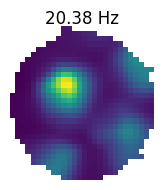

In [24]:
fig, ax = plt.subplots(figsize=(2,2))
cluid = 'jp486-26032023-0108_751'
plotmap(ax,cluid,myMaps)

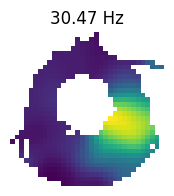

In [25]:
fig, ax = plt.subplots(figsize=(2,2))
cluid = "jp3129-04062022-0108_389"
plotLeverMap(ax,cluid,myLeverMaps,condition='all_light',r='none') #none, arenaref

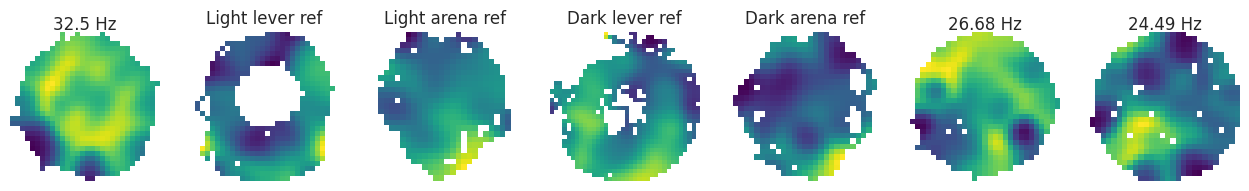

In [26]:
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
cluid = 'jp1686-29042022-0109_25'

nrows_main = 1  # Total rows in the main GridSpec
ncols_main = 7  # Total columns in the main GridSpec
colSize = 1.8
rowSize = 1.8

# Set Seaborn aesthetics
sns.set(rc={"figure.dpi": 100, 'savefig.dpi': 100})
sns.set_theme(style='ticks')

# Create the main figure with the specified size
fig = plt.figure(figsize=(ncols_main * colSize, nrows_main * rowSize), constrained_layout=True)
gs = GridSpec(nrows_main, ncols_main, figure=fig)


ax0 = fig.add_subplot(gs[0])
plotmap(ax0,cluid,myMaps)

ax0 = fig.add_subplot(gs[1])
plotLeverMap(ax0,cluid,myLeverMaps,condition='all_light',r='none')
ax0.set_title('Light lever ref')

ax0 = fig.add_subplot(gs[2])
plotLeverMap(ax0,cluid,myLeverMaps,condition='all_light',r='arenaref')
ax0.set_title('Light arena ref')

ax0 = fig.add_subplot(gs[3])
plotLeverMap(ax0,cluid,myLeverMaps,condition='all_dark',r='none')
ax0.set_title('Dark lever ref')

ax0 = fig.add_subplot(gs[4])
plotLeverMap(ax0,cluid,myLeverMaps,condition='all_dark',r='arenaref')
ax0.set_title('Dark arena ref')

ax0 = fig.add_subplot(gs[5])
plotmap(ax0,cluid,myMaps,condition='circ80_lever1')


ax0 = fig.add_subplot(gs[6])
plotmap(ax0,cluid,myMaps,condition='circ80_lever2')


# non-grid cells with lever modulation

In [27]:
# Plot the distribution of map similarity and compare with shuffle

In [28]:
dfMapCor

,condition,r,session,mouse,cellId
0,o1o2,0.568427,mn8578-30112021-0107,mn8578,mn8578-30112021-0107_20
1,o1o2,0.200241,mn8578-30112021-0107,mn8578,mn8578-30112021-0107_22
2,o1o2,NaN,mn8578-30112021-0107,mn8578,mn8578-30112021-0107_45
3,o1o2,NaN,mn8578-30112021-0107,mn8578,mn8578-30112021-0107_48
4,o1o2,0.582745,mn8578-30112021-0107,mn8578,mn8578-30112021-0107_57
...,...,...,...,...,...
260395,oL1oL2,NaN,jp499-25052023-0108,jp499,jp499-25052023-0108_523
260396,oL1oL2,NaN,jp499-25052023-0108,jp499,jp499-25052023-0108_528
260397,oL1oL2,NaN,jp499-25052023-0108,jp499,jp499-25052023-0108_530
260398,oL1oL2,NaN,jp499-25052023-0108,jp499,jp499-25052023-0108_533


(-1.0, 1.0)

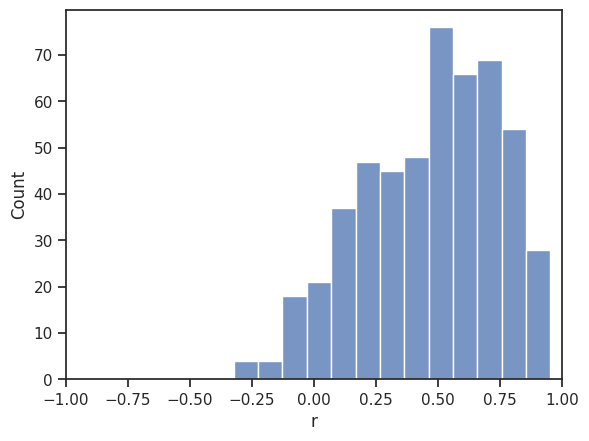

In [29]:
fig, ax =plt.subplots()

sns.histplot(data=dfMapCor[(dfMapCor.condition == 'oL1oL2')],x='r')

ax.set_xlim(-1,1)

In [30]:
dfMapCor[dfMapCor.cellId == 'jp451-05112022-0110_24']

,condition,r,session,mouse,cellId
3931,o1o2,0.856527,jp451-05112022-0110,jp451,jp451-05112022-0110_24
14781,o1o2c,0.828933,jp451-05112022-0110,jp451,jp451-05112022-0110_24
25631,o1l,0.479115,jp451-05112022-0110,jp451,jp451-05112022-0110_24
36481,o1d,0.115270,jp451-05112022-0110,jp451,jp451-05112022-0110_24
47331,ld,0.096283,jp451-05112022-0110,jp451,jp451-05112022-0110_24
58181,l1l2,0.917860,jp451-05112022-0110,jp451,jp451-05112022-0110_24
69031,d1d2,0.864742,jp451-05112022-0110,jp451,jp451-05112022-0110_24
79881,slsd,0.911073,jp451-05112022-0110,jp451,jp451-05112022-0110_24
90731,hlhd,-0.051179,jp451-05112022-0110,jp451,jp451-05112022-0110_24
101581,slhl,-0.029573,jp451-05112022-0110,jp451,jp451-05112022-0110_24


# Find “lever cells” in the RF-Lever, the rest are non-lever cells

For the task:

Detection thresholds:

- Rate peak in the rate-distance map is significantly above shuffling distribution
- Peak rate in the lever map > 7 Hz
- Correlation between 2 independent sets of trials > 0.4

In [31]:
# First, get a 18cm lever-map of RF-lever
# Next, find cells with above 7 Hz peak rate
# Next, find cells with correlation > 0.4

In [32]:
# Sessions to work with:
sessionsWithLastLeverSession = ['jp1686-29042022-0109',
                                'jp3120-27052022-0110',
                                'jp451-05112022-0110',
                                'jp452-25112022-0110',
                                'jp3269-30112022-0110',
                                'jp486-27032023-0110',
                                'jp497-11052023-0110',
                                'jp499-26052023-0110']

In [33]:
sessionsWithLastLeverSession

['jp1686-29042022-0109',
 'jp3120-27052022-0110',
 'jp451-05112022-0110',
 'jp452-25112022-0110',
 'jp3269-30112022-0110',
 'jp486-27032023-0110',
 'jp497-11052023-0110',
 'jp499-26052023-0110']

# Get shuffled distribution peaks

In [34]:
def load_spikeA_one_session(ses,pose_file_extension = ".pose.npy"):

    ses.load_parameters_from_files() 
    ap = Animal_pose(ses)
    ap.pose_file_extension = pose_file_extension # This means that the ap will always load from this extension
    ap.load_pose_from_file()
    stl = Spike_train_loader()
    stl.load_spike_train_kilosort(ses)
    cg = Cell_group(stl,ap)
    # we want to keep ap and cg after the function ends, one way is to store it in our sSes
    ses.ap = ap
    ses.cg = cg
    
def add_circ80_with_lever_intervals(ses,sSes):
    """
    This will add circ80_lever1 and circ80_lever2 to the ses.intervalDict if they were in the session
    """
    for code in ["circ80_lever1","circ80_lever2"]:
    
        indices = [i for i, j in enumerate(sSes.desen) if j == code]
        #
        if len(indices) == 1:
            inter = sSes.trial_intervals.inter[indices[:],:] # the two trials
            ses.intervalDict[code] = inter    
            
def load_data_for_session(sesName):
    session = sesName
    
    sSes = [sSes for sSes in sSessions if sSes.name == session][0]
    ses = myProject.getSession(session)
    
    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)
        
    load_spikeA_one_session(sSes)

    getSearchHomingIntervals(ses,sSes)
    add_circ80_with_lever_intervals(ses,sSes)
    
    return ses, sSes

In [35]:
ses, sSes = load_data_for_session('jp1686-29042022-0109')

In [36]:
from os.path import exists

def distanceToLeverBox(ses,sSes,maxDistance=30):
    """
    Get the distance fo the animal from the lever box, set value above maxDistance to np.nan
    
    Get the walls of the lever box to get distance
    """

    fn = sSes.path+"/leverBoxDistance.npy"
    
    if exists(fn):
        #print(fn,"exists")
        D = np.load(fn)
        print(D)
    
    D[D>maxDistance] = np.nan
    return D

def distanceToLeverCenter(ses,sSes,maxDistance=30,customLeverBox=[-10,-10]):
    """
    Get distance of the animal from the lever center, set value above maxDistance to np.nan
    
    Use lever center to get distance.
    
    We use this function for the last two random foraging with lever because the lever doesn't move.
    """
    
    leverX = customLeverBox[0]
    leverY = customLeverBox[1]
    
    # transform the animal position so that it is centered on lever
    mouseX = sSes.ap.pose[:,1]-leverX
    mouseY = sSes.ap.pose[:,2]-leverY
    
    # distance to lever
    D = np.sqrt(mouseX**2+mouseY**2)  
    
    D[D>maxDistance] = np.nan
    
    return D

def getDistanceRateHisto(ses,sSes,interName="dark",maxDistance=30, iterations=100,percentile=0.95):
    """
    Get all the lever-centered histograms of the data within the intervals of interest
    
    The occupancy histograms is also returned
    
    It also gives you the peak firing rate in the histogram that you would expect to get by chance, if spikes are moved in time on the path. 
    
    """
   
    # change the x and y position of the mouse so that it is relative to the lever position
    #print(ses.name)
    
    sSes.ap.load_pose_from_file() # get original hd data, which file depends on what we used when calling prepareSessionsForSpatialAnalysis
    
    D = distanceToLeverCenter(ses,sSes,maxDistance=maxDistance)
    mouseX= D
    
    # replace x by mouseX in ap.pose_ori[:1]
    sSes.ap.pose_ori[:,1] = mouseX
    sSes.ap.set_intervals(ses.intervalDict[interName])
    
    for n in sSes.cg.neuron_list:
        n.spike_train.set_intervals(ses.intervalDict[interName])
        n.spatial_properties.firing_rate_histogram(cm_per_bin =1, smoothing_sigma_cm = 1, smoothing=True,x_range = np.array([0,maxDistance]) )
        
    mapStack = np.vstack([ n.spatial_properties.firing_rate_histo for n in sSes.cg.neuron_list ])
    occStack = np.vstack([ n.spatial_properties.ap.occupancy_histo for n in sSes.cg.neuron_list ])
    

    def runShufflePeakRate(n):
        """
        Function to implement the shuffle procedure to get chance levels for the peak rates 
        
        The shuffle will include all time periods of the interName type (e.g., dark). This means that periods away from the lever gets into the histograms.
        The focus on 0,30 is when making the histogram. 
        """
        # allocate memory for the shuffle data
        peaks_shuffle=np.empty(iterations)
        for i in range(iterations):
            sSes.ap.roll_pose_over_time() # shuffle the position data on each iteration by a random amount
            n.spatial_properties.firing_rate_histogram(cm_per_bin =1, smoothing_sigma_cm = 1, smoothing=True,x_range = np.array([0,maxDistance])) 
            peaks_shuffle[i] =  np.nanmax(n.spatial_properties.firing_rate_histo)
            
        # calculate the threshold
        peak_threshold =  np.percentile(peaks_shuffle,percentile)
        return(peak_threshold)
        
        
    # do the shuffle to get the chance lever for the peak firing rate
    peakThresholds = np.array([runShufflePeakRate(n) for n in sSes.cg.neuron_list])
    
    
    sSes.ap.load_pose_from_file() # get original position data
    
    return mapStack,occStack,peakThresholds

# Load lever pose

In [37]:
import os 
import pickle

BASE_ROOT = myProject.dataPath

# Plot individual cells and lever centered map in RF3_L1 and RF3_L2
def get_file_root(session_name):
    mouseName = session_name.split('-')[0]
    root_path = os.path.join(BASE_ROOT,mouseName,session_name)
    return root_path

def get_lever_pose_by_sessions(sessionName):
    if sessionName not in sessionsWithLastLeverSession:
        raise ValueError('This session does not have a lever session')
    
    root_fn = get_file_root(sessionName)
    
    # Specify the filename
    lever_fn = os.path.join(root_fn,'circ80_lever_pose.pkl')
    
    # Load the pickle file
    with open(lever_fn, 'rb') as file:
        data = pickle.load(file)
        
    return data
    

In [38]:
testSes = 'jp1686-29042022-0109'

In [39]:
get_lever_pose_by_sessions(testSes)

{'circ80_lever1': array([-15.86382469, -15.43146114]),
 'circ80_lever2': array([-14.37389399,  11.98086784])}

# Test lever centered map

In [40]:
from scipy.ndimage import shift
    
def getLeverMapsInRF3(ses,sSes,LeverPoseRF3,interName="circ80_lever1",maxDistance=18, rotationType="none",smooth=True,
                 invalidateSmallBridgeAngle=False,invalidateMaxAngle=np.pi/12,
                 rateType="map",stats=False):
    """
    Get all the lever-centered firing rate maps or firing rate polar plots around the lever. The data can be plotted in different reference coordinate system.
    The lever position is set to 0,0.
    The orientation is either unchanged ("none") or relative to the vector going from the lever to the bridge ("bridge") or relative to the lever orientation ("lever")
    
    
    Arguments
    ses: autopipy session
    sSes: spikeA session
    interName: name of intervals to use (from ses.intervalDict) # We should only use 'circ80_lever1', 'circ80_lever2' for this function
    LeverPoseRF3: We need to input the position of the lever for this session, this should be a tuple [leverX,leverY]
    maxDistance: max distance from lever
    rotationType: can be "none","bridge","lever", once centered on the lever,
                    we can rotate the position to have different reference frame (cartesian (none), relative to bridge direction, relative to lever orientation)
    invalidateSmallBridgeAngle: whether to invalidate lever position when the bridge angle is small (for which cartesian and brdige reference frames are the same)
                                This is done to eliminate data when the none and brdige rotations are the same
                                This can be used to better contrast the prediction of "bridge" and "none" rotation
    invalidateMaxAngle: angle below which we invalidate
    rateType: (map) firing rate maps or (angular) angular rate histogram
    stats: whether to return the statistics instead of the map.
    
    """
   
    # change the x and y position of the mouse so that it is relative to the lever position
    
    sSes.ap.load_pose_from_file() # get original position data, which file depends on what we used when calling prepareSessionsForSpatialAnalysis
    
    cm_per_bin = 3
    
    def shift_heatmap(heatmap,leverPose=LeverPoseRF3):
        # Function to shift the heatmap so that it's lever centered
        im = shift(
        heatmap,
        shift=-leverPose/cm_per_bin,
        mode='constant',
        cval=np.nan,
        order=0  # Use nearest-neighbor interpolation to preserve NaNs
        )
            
        return im
    
    leverX,leverY = LeverPoseRF3
    
    mouseX = sSes.ap.pose_ori[:,1]-leverX
    mouseY = sSes.ap.pose_ori[:,2]-leverY

    D = np.sqrt(mouseX**2+mouseY**2)
        
    sSes.ap.pose_ori[:,1] = mouseX
    sSes.ap.pose_ori[:,2] = mouseY
        
    sSes.ap.pose_ori[:,1][D>maxDistance]= np.nan
    sSes.ap.pose_ori[:,2][D>maxDistance]= np.nan
    
    sSes.ap.set_intervals(ses.intervalDict[interName])

    cellName_holder = []    
    if rateType=="map": # normal 2D maps
        for n in sSes.cg.neuron_list:
            n.spike_train.set_intervals(ses.intervalDict[interName])
            cluid = f"{ses.name}_{n.name}"
            cellName_holder.append(cluid)
            if stats==False:
                    n.spatial_properties.firing_rate_map_2d(cm_per_bin =cm_per_bin, smoothing_sigma_cm = 5, 
                                                            smoothing=smooth,xy_range = np.array([[-maxDistance,-maxDistance],[maxDistance,maxDistance]])) #np.array([[-50,-50],[50,50]]
            else:
                    n.spatial_properties.firing_rate_map_2d(cm_per_bin =cm_per_bin, smoothing_sigma_cm = 0, 
                                                            smoothing=smooth,xy_range = np.array([[-maxDistance,-maxDistance],[maxDistance,maxDistance]]))
        if stats==False:
            mapList = [ n.spatial_properties.firing_rate_map for n in sSes.cg.neuron_list ]
            mapStack = np.stack(mapList, axis=0)
        else:
            mapList = [ n.spatial_properties.firing_rate_map for n in sSes.cg.neuron_list ]
            mapStack = np.stack(mapList, axis=0) 
    
    else:
        print("rateType not supported")
    
    sSes.ap.load_pose_from_file() # get original position data
    cellStack = np.stack(cellName_holder,axis = 0)
    
    return mapStack, cellStack

In [41]:
rateType="map"
testSes = 'jp1686-29042022-0109'
ses, sSes = load_data_for_session(testSes)

In [42]:
lever_pose_for_session = get_lever_pose_by_sessions(testSes)

In [43]:
lever_pose_for_session

{'circ80_lever1': array([-15.86382469, -15.43146114]),
 'circ80_lever2': array([-14.37389399,  11.98086784])}

In [44]:
lever1Pose = lever_pose_for_session['circ80_lever1']
lever2Pose = lever_pose_for_session['circ80_lever2']

In [45]:
map, cellIds = getLeverMapsInRF3(ses,sSes,LeverPoseRF3=lever1Pose,interName="circ80_lever1",maxDistance=80,
                       invalidateSmallBridgeAngle=False, rateType=rateType,stats=False)

In [46]:
map2, cellIds2 = getLeverMapsInRF3(ses,sSes,LeverPoseRF3=lever2Pose,interName="circ80_lever2",maxDistance=80,
                       invalidateSmallBridgeAngle=False, rateType=rateType,stats=False)

In [47]:
map.shape

(12, 54, 54)

In [ ]:
# # Initialize the dictionary outside the loop
# mapDictionary = {}

# for session_with_lever in sessionsWithLastLeverSession:
#     rateType="map"
#     ses, sSes = load_data_for_session(session_with_lever)
    
#     lever_pose_for_session = get_lever_pose_by_sessions(session_with_lever)
    
#     lever1Pose = lever_pose_for_session['circ80_lever1']
#     lever2Pose = lever_pose_for_session['circ80_lever2']
    
#     map_l1, cellIds_l1 = getLeverMapsInRF3(ses,sSes,LeverPoseRF3=lever1Pose,interName="circ80_lever1",maxDistance=80,
#                        invalidateSmallBridgeAngle=False, rateType=rateType,stats=False)
    
#     map_l2, cellIds_l2 = getLeverMapsInRF3(ses,sSes,LeverPoseRF3=lever2Pose,interName="circ80_lever2",maxDistance=80,
#                        invalidateSmallBridgeAngle=False, rateType=rateType,stats=False)
    
#     # Ensure both cell ID lists are identical
#     assert np.all(cellIds_l1 == cellIds_l2), "Cell IDs do not match between lever1 and lever2"
    
#     # Iterate through each cell and its corresponding maps
#     for cellId, map1, map2 in zip(cellIds_l1, map_l1, map_l2):
#         # Initialize sub-dictionary for the cellId if it doesn't exist
#         if cellId not in mapDictionary:
#             mapDictionary[cellId] = {'circ80_lever1': [], 'circ80_lever2': []}
        
#         # Append the maps to their respective lever type lists
#         mapDictionary[cellId]['circ80_lever1'].extend(map1)
#         mapDictionary[cellId]['circ80_lever2'].extend(map2)

In [ ]:
# # NOTE SAVE DICTIONARY CONTAINING LEVER MAP
# fn = myProject.dataPath + '/results/myLeverMaps_last_lever_sessions_80.pickle'
# print("saving:",fn)
# with open(fn, 'wb') as handle:
#     pickle.dump(mapDictionary, handle)

saving: /adata/projects/autopi_mec/results/myLeverMaps_last_lever_sessions_80.pickle


# Correlation with lever maps

In [50]:
def remove_nans(inputMap):
    im=inputMap[:,~np.isnan(inputMap).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    return im

In [51]:
from scipy.stats import pearsonr
from matplotlib.gridspec import GridSpecFromSubplotSpec

def map_cor(a,b):
    """
    Correlation coefficient between two firing rate maps
    
    Arguments:
    a: 2D np.array (map1)
    b: 2D np.array (map2)
    
    Returns:
    Pearson correlation coefficient between a and b
    """
    a = a.flatten()
    b = b.flatten()
    indices = np.logical_and(~np.isnan(a), ~np.isnan(b))
    r,p = pearsonr(a[indices],b[indices])
    return r, a[indices],b[indices]

In [52]:
# NOTE LOAD DICTIONARY CONTAINING LEVER MAP
fn = myProject.dataPath + '/results/myLeverMaps_last_lever_sessions_80.pickle'
print("Loading:",fn)
with open(fn, 'rb') as file:
    mapDictionary = pickle.load(file)

Loading: /ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/myLeverMaps_last_lever_sessions_80.pickle


In [53]:
cellHolder = []
corrHolder = []
aHolder = []
bHolder = []
    
for cells_with_lever_sessions in mapDictionary.keys():
    cellHolder.append(cells_with_lever_sessions)
    
    leverMap1 = np.array(mapDictionary[cells_with_lever_sessions]['circ80_lever1'])
    leverMap2 = np.array(mapDictionary[cells_with_lever_sessions]['circ80_lever2'])
    r,a,b=map_cor(leverMap1,leverMap2)
    
    corrHolder.append(r)
    aHolder.append(a)
    bHolder.append(b)

/home/kilo/miniconda3/envs/spikeA/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [54]:
mapSimilarityDf = pd.DataFrame({'cluId':cellHolder,'correlation':corrHolder,'cell1_map':aHolder,'cell2_map':bHolder})

In [55]:
mapSimilarityDf

,cluId,correlation,cell1_map,cell2_map
0,jp1686-29042022-0109_25,-0.056490,"[8.027816809254231, 12.805460961699692, 11.918...","[14.288689358656233, 9.488383280386733, 11.214..."
1,jp1686-29042022-0109_26,-0.137086,"[3.8946960469773937, 3.3598299659944653, 3.246...","[3.7405708946313285, 6.553752943299048, 7.2194..."
2,jp1686-29042022-0109_27,0.028550,"[1.9580838847614668, 2.851928252246367, 2.5591...","[1.6816135089706763, 1.637171985810788, 1.8936..."
3,jp1686-29042022-0109_28,0.559432,"[9.401636552413532, 11.02459276313178, 10.5793...","[6.380999080037923, 6.195833305209349, 5.73813..."
4,jp1686-29042022-0109_39,0.219890,"[9.657696819835815, 12.099260688144057, 11.793...","[9.065481792537897, 9.063394008486728, 9.77536..."
...,...,...,...,...
513,jp499-26052023-0110_598,0.693513,"[2.7449075153262386, 2.933731683366571, 3.2974...","[1.2200574534392614, 1.4098909924267942, 1.673..."
514,jp499-26052023-0110_606,0.450548,"[6.504866475381477, 6.2852528055487085, 5.6918...","[5.066232200763605, 4.761913631288876, 4.31306..."
515,jp499-26052023-0110_608,0.167750,"[4.9868336961211766, 5.260979468183137, 5.6375...","[6.167160354785672, 5.642696480174697, 5.02033..."
516,jp499-26052023-0110_612,0.200783,"[24.686552906217994, 26.897967211043948, 29.73...","[22.86251245971263, 23.429809969325813, 23.791..."


In [56]:
# Correlate their original mapCorr
cH = []
corH = []
cell1H = []
cell2H = []
    
for cells_with_lever_sessions in mapDictionary.keys():
    cH.append(cells_with_lever_sessions)
    
    mapindex=ct[ct.cluId==cells_with_lever_sessions].cluId
    leverMap1=myMaps['circ80_lever1'][mapindex.index][0]
    leverMap2=myMaps['circ80_lever2'][mapindex.index][0]
    
    
    r,a,b=map_cor(leverMap1,leverMap2)
    
    corH.append(r)
    cell1H.append(a)
    cell2H.append(b)

/home/kilo/miniconda3/envs/spikeA/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [57]:
mapSimilarityDfOri = pd.DataFrame({'cluId':cH,'ori_correlation':corH,'cell1_map_ori':cell1H,'cell2_map_ori':cell2H})

In [58]:
mapSimilarityDf = mapSimilarityDf.merge(mapSimilarityDfOri,on='cluId',how='left')

-0.2373985857044999


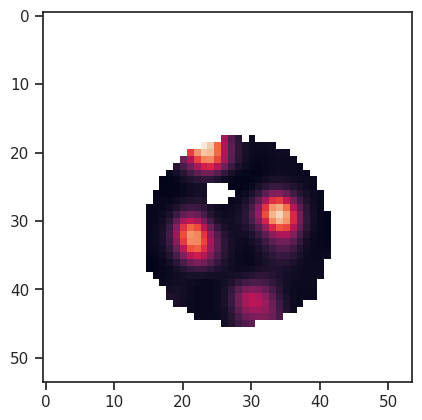

In [59]:
testCell = 'jp3269-30112022-0110_202'

leverMap1 = np.array(mapDictionary[testCell]['circ80_lever1'])
leverMap2 = np.array(mapDictionary[testCell]['circ80_lever2'])

plt.imshow(leverMap1)

r, a,b = map_cor(leverMap1,leverMap2)
print(r)

In [60]:
mapSimilarityDf = mapSimilarityDf.merge(cells,on='cluId',how='left')

In [61]:
mapSimilarityDf = mapSimilarityDf[mapSimilarityDf.usable]

In [62]:
mapSimilarityDf.columns

Index(['cluId', 'correlation', 'cell1_map', 'cell2_map', 'ori_correlation',
       'cell1_map_ori', 'cell2_map_ori', 'session', 'mouse', 'refractory',
       'refractoryClean', 'usable', 'meanRate', 'sumShortAuto',
       'meanRateStable', 'gridCell_AND', 'gridCell_OR', 'gridCell_FIRST',
       'gridCell', 'leverCell_all_light', 'leverCell_all_dark'],
      dtype='object')

In [63]:
mapSimilarityDf

,cluId,correlation,cell1_map,cell2_map,ori_correlation,cell1_map_ori,cell2_map_ori,session,mouse,refractory,...,usable,meanRate,sumShortAuto,meanRateStable,gridCell_AND,gridCell_OR,gridCell_FIRST,gridCell,leverCell_all_light,leverCell_all_dark
0,jp1686-29042022-0109_25,-0.056490,"[8.027816809254231, 12.805460961699692, 11.918...","[14.288689358656233, 9.488383280386733, 11.214...",-0.319593,"[8.644825466100679, 7.540887641790062, 8.41038...","[4.902938283377122, 6.571407048950793, 5.58235...",jp1686-29042022-0109,jp1686,0.043426,...,True,16.237164,134732.0,True,False,False,False,False,False,True
7,jp1686-29042022-0109_67,0.172660,"[0.501414678795333, 8.539840664032393, 6.93036...","[1.0026354900689116, 1.0921014782681255, 1.771...",0.720958,"[0.41344604475655466, 0.7368106385663905, 0.44...","[0.42917110186050966, 0.5872340136864235, 0.46...",jp1686-29042022-0109,jp1686,0.017596,...,True,4.748953,75573.0,True,True,True,True,True,True,True
10,jp1686-29042022-0109_91,0.019945,"[3.631555551567182, 5.293718793186121, 4.85879...","[3.6250355286570644, 2.8224935193124536, 3.154...",0.267138,"[3.8330874761668943, 3.621920630867898, 3.8049...","[2.6429986745553045, 2.8320254418048156, 2.712...",jp1686-29042022-0109,jp1686,0.134273,...,True,6.762359,34910.0,True,False,False,False,False,False,False
11,jp1686-29042022-0109_99,0.058919,"[7.172668201787784, 12.446718114619912, 11.640...","[9.391060360715173, 7.922803135687149, 8.87201...",0.193197,"[7.7287221363626, 6.929053845082419, 7.3466032...","[5.010817480452683, 6.569875481759415, 5.74449...",jp1686-29042022-0109,jp1686,0.000322,...,True,12.392585,81000.0,True,False,False,False,False,True,False
13,jp1686-29042022-0109_107,-0.019358,"[8.151142541039743, 1.5990030434385323, 3.0187...","[2.758314126653154, 1.9030355332124536, 2.1543...",0.538359,"[8.311211128723315, 7.858793702103368, 7.93382...","[1.4741356234300353, 1.3144710154789185, 1.428...",jp1686-29042022-0109,jp1686,0.034563,...,True,3.573728,33929.0,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,jp499-26052023-0110_580,0.412389,"[22.795332494306937, 23.108942630547904, 23.99...","[28.382533882520146, 29.83519969604338, 31.013...",0.446401,"[26.165987268289435, 24.204226537157574, 22.74...","[25.70833137874071, 23.01539747319909, 21.1651...",jp499-26052023-0110,jp499,0.089600,...,True,23.841705,346874.0,True,False,False,False,False,True,True
510,jp499-26052023-0110_582,-0.100336,"[1.7715873627640972, 2.551099756450873, 3.5456...","[3.112526801409968, 2.50528348244532, 1.991745...",0.381417,"[1.008114623808693, 1.1704834015794594, 1.4768...","[1.6922130448780617, 1.9903513320014043, 2.453...",jp499-26052023-0110,jp499,0.111362,...,True,2.126778,17435.0,True,False,False,False,False,True,True
511,jp499-26052023-0110_592,0.648934,"[1.30604947144794, 1.651113301949775, 2.114351...","[1.3477068224203717, 1.5571975455339864, 1.725...",0.425814,"[0.6807655209820538, 0.8528898685992063, 1.073...","[2.106883011310431, 2.2485418047276102, 2.4074...",jp499-26052023-0110,jp499,0.061713,...,True,1.936013,9207.0,True,False,False,False,False,False,False
513,jp499-26052023-0110_598,0.693513,"[2.7449075153262386, 2.933731683366571, 3.2974...","[1.2200574534392614, 1.4098909924267942, 1.673...",0.069291,"[2.1374375700398454, 2.49854562671206, 2.71869...","[5.303383941833121, 7.047042184721386, 8.72959...",jp499-26052023-0110,jp499,0.054275,...,True,2.613022,26062.0,True,False,False,False,False,True,True


In [64]:
mapSimilarityDfG = mapSimilarityDf[mapSimilarityDf.gridCell_FIRST].groupby(["mouse"]).correlation.mean().reset_index()
mapSimilarityDfG = mapSimilarityDfG.rename(columns ={'correlation':'corr'})
mapSimilarityDfG['ref'] = 'Lever ref.'

In [65]:
mapSimilarityDfGO=mapSimilarityDf[mapSimilarityDf.gridCell_FIRST].groupby(["mouse"]).ori_correlation.mean().reset_index()
mapSimilarityDfGO = mapSimilarityDfGO.rename(columns = {'ori_correlation':'corr'})
mapSimilarityDfGO['ref'] = 'Room'


In [66]:
mapSimilarityDfG = pd.concat([mapSimilarityDfG,mapSimilarityDfGO])

In [67]:
mapSimilarityDfG

,mouse,corr,ref
0,jp1686,0.050187,Lever ref.
1,jp3120,-0.145785,Lever ref.
2,jp3269,0.057623,Lever ref.
3,jp452,-0.101801,Lever ref.
4,jp486,-0.070182,Lever ref.
0,jp1686,0.638118,Room
1,jp3120,0.737013,Room
2,jp3269,0.545683,Room
3,jp452,0.734349,Room
4,jp486,0.590534,Room


In [68]:
boxprops = {"edgecolor": "k", "linewidth": 1.5}
lineprops = {"color": "k", "linewidth": 1.5}
histprops = {"linewidth": 1.5}
arrowParams = {"headwidth": 4, "headlength": 6, "headaxislength": 5.5}

boxplot_kwargs = dict(
    {
        "boxprops": boxprops,
        "medianprops": lineprops,
        "whiskerprops": lineprops,
        "capprops": lineprops,
    }
)  #'width': 0.75
stripplot_kwargs = dict(
    {"linewidth": 1, "size": 5, "alpha": 0.8},
)

In [69]:
GLOBALFONTSIZE=11

def plot_lever_ref_boxplot(ax,inputDf):
    pal = ['#ff9f1c','#2ec4b6']
    b = sns.boxplot(data=inputDf,x='ref',y='corr',palette=pal, **boxplot_kwargs)
    sns.stripplot(data=inputDf,x='ref',y='corr',palette=pal,**stripplot_kwargs)

    ax.set_ylim(-0.2,1)
    ax.set_ylabel('Map similarity (r)',fontsize=GLOBALFONTSIZE)
    
    ax.set_xticklabels(['Lever cent.','Room ref.'],fontsize=GLOBALFONTSIZE)
    #ax.set_xlabel('Reference frame',fontsize=GLOBALFONTSIZE)
    ax.set_xlabel('')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [70]:
mapSimilarityDf['roomCorSubtractLeverCor'] = mapSimilarityDf['ori_correlation'] - mapSimilarityDf['correlation']

/tmp/ipykernel_115550/4035666027.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=inputDf,x='ref',y='corr',palette=pal,**stripplot_kwargs)


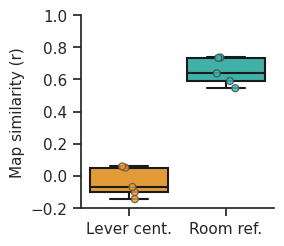

In [71]:
fig, ax =plt.subplots(figsize=(2.5,2.5))

sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_theme(style='ticks')

plot_lever_ref_boxplot(ax,mapSimilarityDfG)



In [72]:
mapSimilarityDfG[mapSimilarityDfG.ref == 'Room']['corr'].values

array([0.63811773, 0.73701285, 0.54568262, 0.73434923, 0.59053405])

In [73]:
import scipy
scipy.stats.wilcoxon(mapSimilarityDfG[mapSimilarityDfG.ref == 'Room']['corr'].values,mapSimilarityDfG[mapSimilarityDfG.ref == 'Lever ref.']['corr'].values)

WilcoxonResult(statistic=0.0, pvalue=0.0625)

In [74]:
compare_corr(mapSimilarityDfG[mapSimilarityDfG.ref == 'Room']['corr'].values,mapSimilarityDfG[mapSimilarityDfG.ref == 'Lever ref.']['corr'].values)

Shapiro-Wilk Test: Statistic=0.9392, p-value=0.6603
Normality assumption met. Using Paired t-test: t-statistic=9.2947, p-value=0.0007


{'test': 'Paired t-test',
 'statistic': 9.29472266482769,
 'p-value': 0.0007454417743999343}

In [75]:
mapSimilarityDf = mapSimilarityDf.sort_values('correlation',ascending=False)

In [76]:
mapSimilarityDf.columns

Index(['cluId', 'correlation', 'cell1_map', 'cell2_map', 'ori_correlation',
       'cell1_map_ori', 'cell2_map_ori', 'session', 'mouse', 'refractory',
       'refractoryClean', 'usable', 'meanRate', 'sumShortAuto',
       'meanRateStable', 'gridCell_AND', 'gridCell_OR', 'gridCell_FIRST',
       'gridCell', 'leverCell_all_light', 'leverCell_all_dark',
       'roomCorSubtractLeverCor'],
      dtype='object')

# Make final figure with examples and stats

In [77]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from functools import partial
GLOBALFONTSIZE = 11

import matplotlib.patches as patches

def plot_centered_circle(ax, radius=22, edgecolor='gray', linewidth=2, linestyle='--'):
    """
    Plots a dashed gray circle centered in the given Matplotlib axes.

    Parameters:
    - ax (matplotlib.axes.Axes): The Matplotlib axes to plot the circle on.
    - radius (float): The radius of the circle in data units (typically pixels).
    - edgecolor (str): The color of the circle's edge.
    - linewidth (float): The width of the circle's edge line.
    - linestyle (str): The style of the circle's edge line (e.g., '--' for dashed).
    
    Returns:
    - circle (matplotlib.patches.Circle): The circle patch added to the axes.
    """
    # Retrieve the current axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Calculate the center coordinates
    center_x = (xlim[0] + xlim[1]) / 2
    center_y = (ylim[0] + ylim[1]) / 2

    # Create the circle patch
    circle = patches.Circle(
        (center_x, center_y),  # Center of the circle
        radius=radius,         # Radius of the circle
        edgecolor=edgecolor,   # Border color
        linewidth=linewidth,   # Border width
        linestyle=linestyle,   # Dashed border
        facecolor='none'       # No fill color
    )

    # Add the circle to the axes
    ax.add_patch(circle)

    # Ensure the aspect ratio is equal to maintain the circle's shape
    ax.set_aspect('equal')

    return circle


def add_inset_plot(parent_ax, plot_func, inset_width="50%", inset_height="50%", loc='lower right', borderpad=2, **kwargs):
    """
    Adds an inset plot to a given Matplotlib axis.

    Parameters:
    - parent_ax (matplotlib.axes.Axes): The parent axis to which the inset will be added.
    - plot_func (callable): A function that takes a Matplotlib axis as its first argument and plots on it.
    - inset_width (str or float, optional): Width of the inset axes. Can be a percentage string like "50%" or a fixed size like "3cm". Default is "50%".
    - inset_height (str or float, optional): Height of the inset axes. Can be a percentage string like "50%" or a fixed size like "3cm". Default is "50%".
    - loc (str or int, optional): Location code for the inset. Accepts same values as Matplotlib's `loc` parameter (e.g., 'upper right', 1). Default is 'lower right'.
    - borderpad (int, optional): Padding between the parent and inset axes, measured in font-size multiples. Default is 2.
    - **kwargs: Additional keyword arguments passed to `inset_axes`.

    Returns:
    - inset_ax (matplotlib.axes.Axes): The newly created inset axes.
    """
    # Create inset axes within the parent axis
    inset_ax = inset_axes(parent_ax,
                          width=inset_width,
                          height=inset_height,
                          loc=loc,
                          borderpad=borderpad,
                          **kwargs)
    
    # Call the provided plotting function with the inset axes
    plot_func(inset_ax)
    
    return inset_ax

def plotLeverMapRF3(axes, cluId, maps,condition='all_light',r='none',title=''):
    
    mapToPlot = maps[cluId][condition]
    
    im = np.array(mapToPlot)

    
    axes.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    

    plot_centered_circle(axes)
    axes.set_xlabel(f'{title}',fontsize=GLOBALFONTSIZE-2)
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])
    
def plotmapRF3(axes, cluId, maps,condition='circ80_2',title=''):
    mapindex=ct[ct.cluId==cluId].cluId
    
    im=maps[condition][mapindex.index][0]
    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    axes.set_title(f'{title}',fontsize=GLOBALFONTSIZE-2,pad=-5)
    
    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])
    
    
def plotLeverMap(axes, cluId, maps,condition='all_light',r='none',title='',top=True,showYLabel=True):
    nCells=maps["map"]["all_light"]["none"]['data'].shape[0]
    
    for i in range(nCells):
        if maps["map"][condition][r]['cluid'][i] == cluId:
            mapToPlot = maps["map"][condition][r]['data'][i]
            break
        
    
    im = mapToPlot
    
    axes.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    if top:
        axes.set_title(title,fontsize=GLOBALFONTSIZE-2,pad=-5)
        axes.set_xlabel('')
    else:
        axes.set_xlabel(f'{title}',fontsize=GLOBALFONTSIZE-2)
        
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])
    
        
def plot_room_lever_partial_map_RF3(ax0,cellId,condition='circ80_lever1'):
    
    # Create partial functions for lever and room references
    leverRef_partial = partial(
        plotLeverMapRF3,
        cluId=cellId,
        maps=mapDictionary,
        condition=condition,
        title='Lever-cent.'
    )
    
    roomRef_partial = partial(
        plotmapRF3,
        cluId=cellId,
        maps=myMaps,
        condition=condition,
        title='Room-ref.',
    )
    
    # Add inset plots to the 'At Lever' subplot
    add_inset_plot(ax0, leverRef_partial,
                    inset_width="40%", inset_height="40%",
                    loc='lower right', borderpad=0)

    add_inset_plot(ax0, roomRef_partial,
                    inset_width="66%", inset_height="66%",
                    loc='upper left', borderpad=0)
    
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['left'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_aspect('equal')
   
def plot_room_lever_partial_map(ax0,cellId,condition='all_light'):
    
    # Create partial functions for lever and room references
    leverRef_partial = partial(
        plotLeverMap,
        cluId=cellId,
        maps=myLeverMaps,
        condition=condition,
        title='Lever-ref.',
        r='none',
        top=False
    )
    
    roomRef_partial = partial(
        plotLeverMap,
        cluId=cellId,
        maps=myLeverMaps,
        condition=condition,
        title='Room-ref.',
        r='arenaref'
    )
    
    # Add inset plots to the 'At Lever' subplot
    add_inset_plot(ax0, leverRef_partial,
                    inset_width="40%", inset_height="40%",
                    loc='lower right', borderpad=0)

    add_inset_plot(ax0, roomRef_partial,
                    inset_width="68%", inset_height="68%",
                    loc='upper left', borderpad=0)
    
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['left'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_aspect('equal')


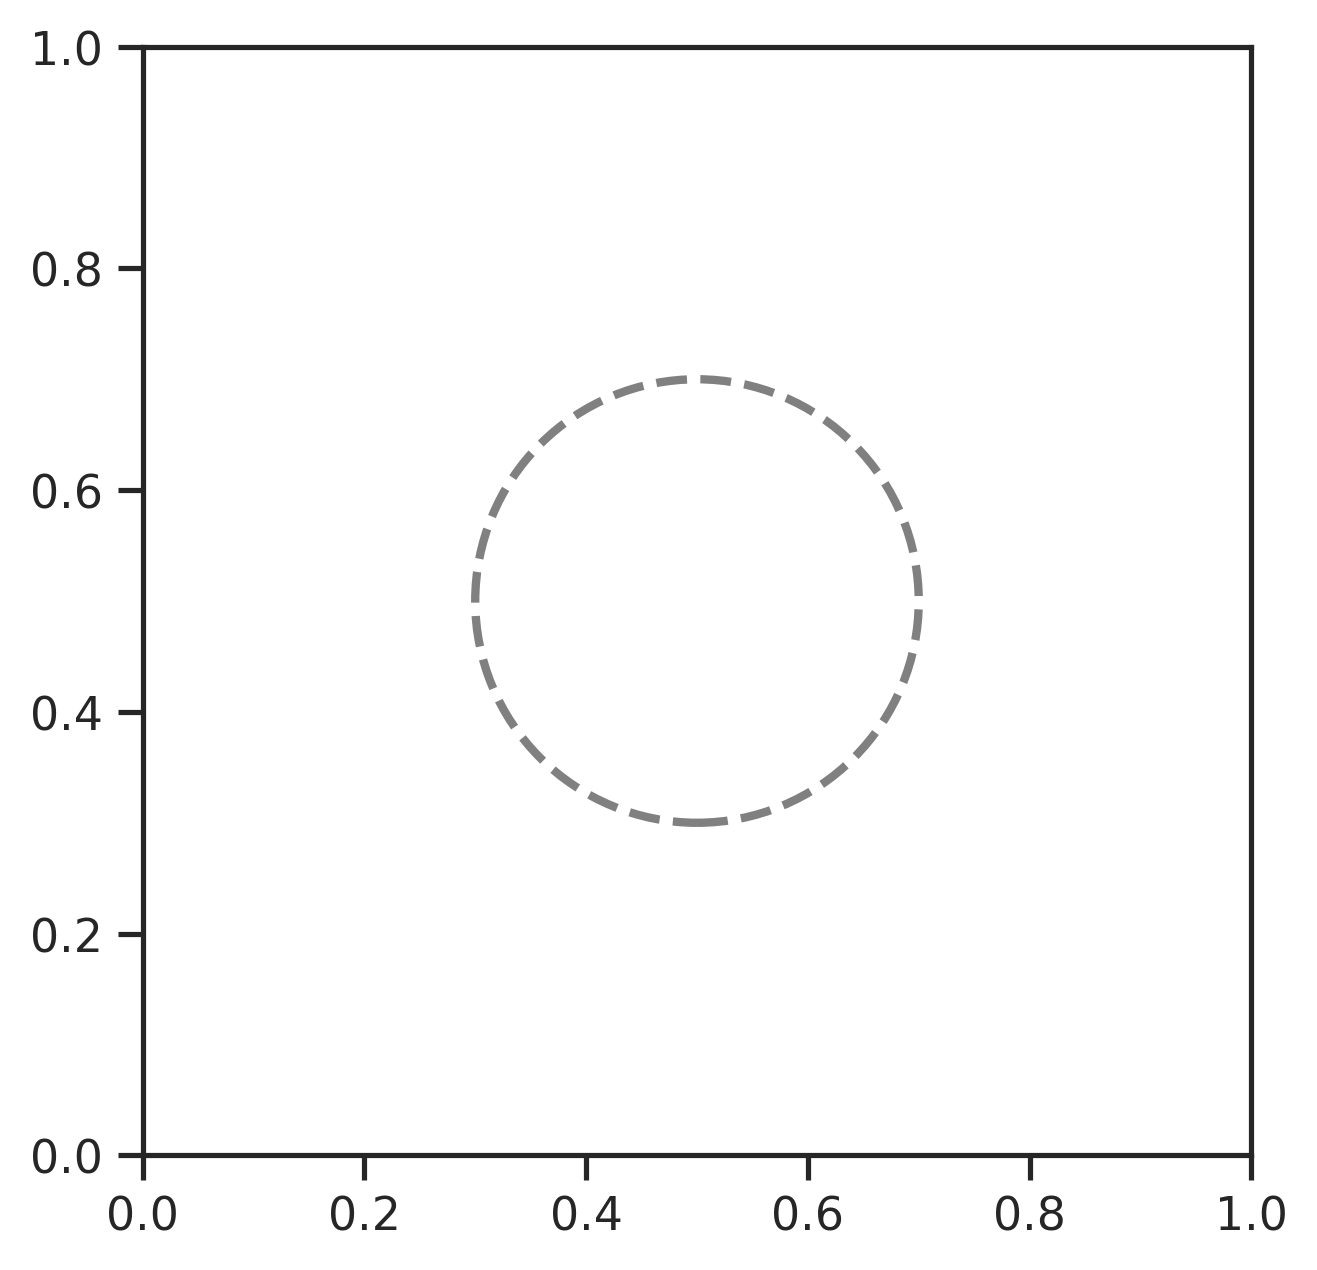

In [78]:
fig, ax =plt.subplots()
plot_centered_circle(ax=ax, radius=0.2, edgecolor='gray', linewidth=2, linestyle='--')


In [79]:
def plot_one_row_of_example_lever_cell(gs0,cluid,ylabel):

    ax0 = fig.add_subplot(gs0[0,0])
    plotmap(ax0,cluid,myMaps,condition='circ80_1')
    ax0.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)

    ax0 = fig.add_subplot(gs0[0,1])
    plot_room_lever_partial_map(ax0,cluid,condition='all_light')

    ax0 = fig.add_subplot(gs0[0,2])
    plotmap(ax0,cluid,myMaps,condition='circ80_2')

    ax0 = fig.add_subplot(gs0[0,3])
    plot_room_lever_partial_map_RF3(ax0,cluid,condition='circ80_lever1')

    ax0 = fig.add_subplot(gs0[0,4])
    plot_room_lever_partial_map_RF3(ax0,cluid,condition='circ80_lever2')

/home/kilo/miniconda3/envs/spikeA/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/kilo/miniconda3/envs/spikeA/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


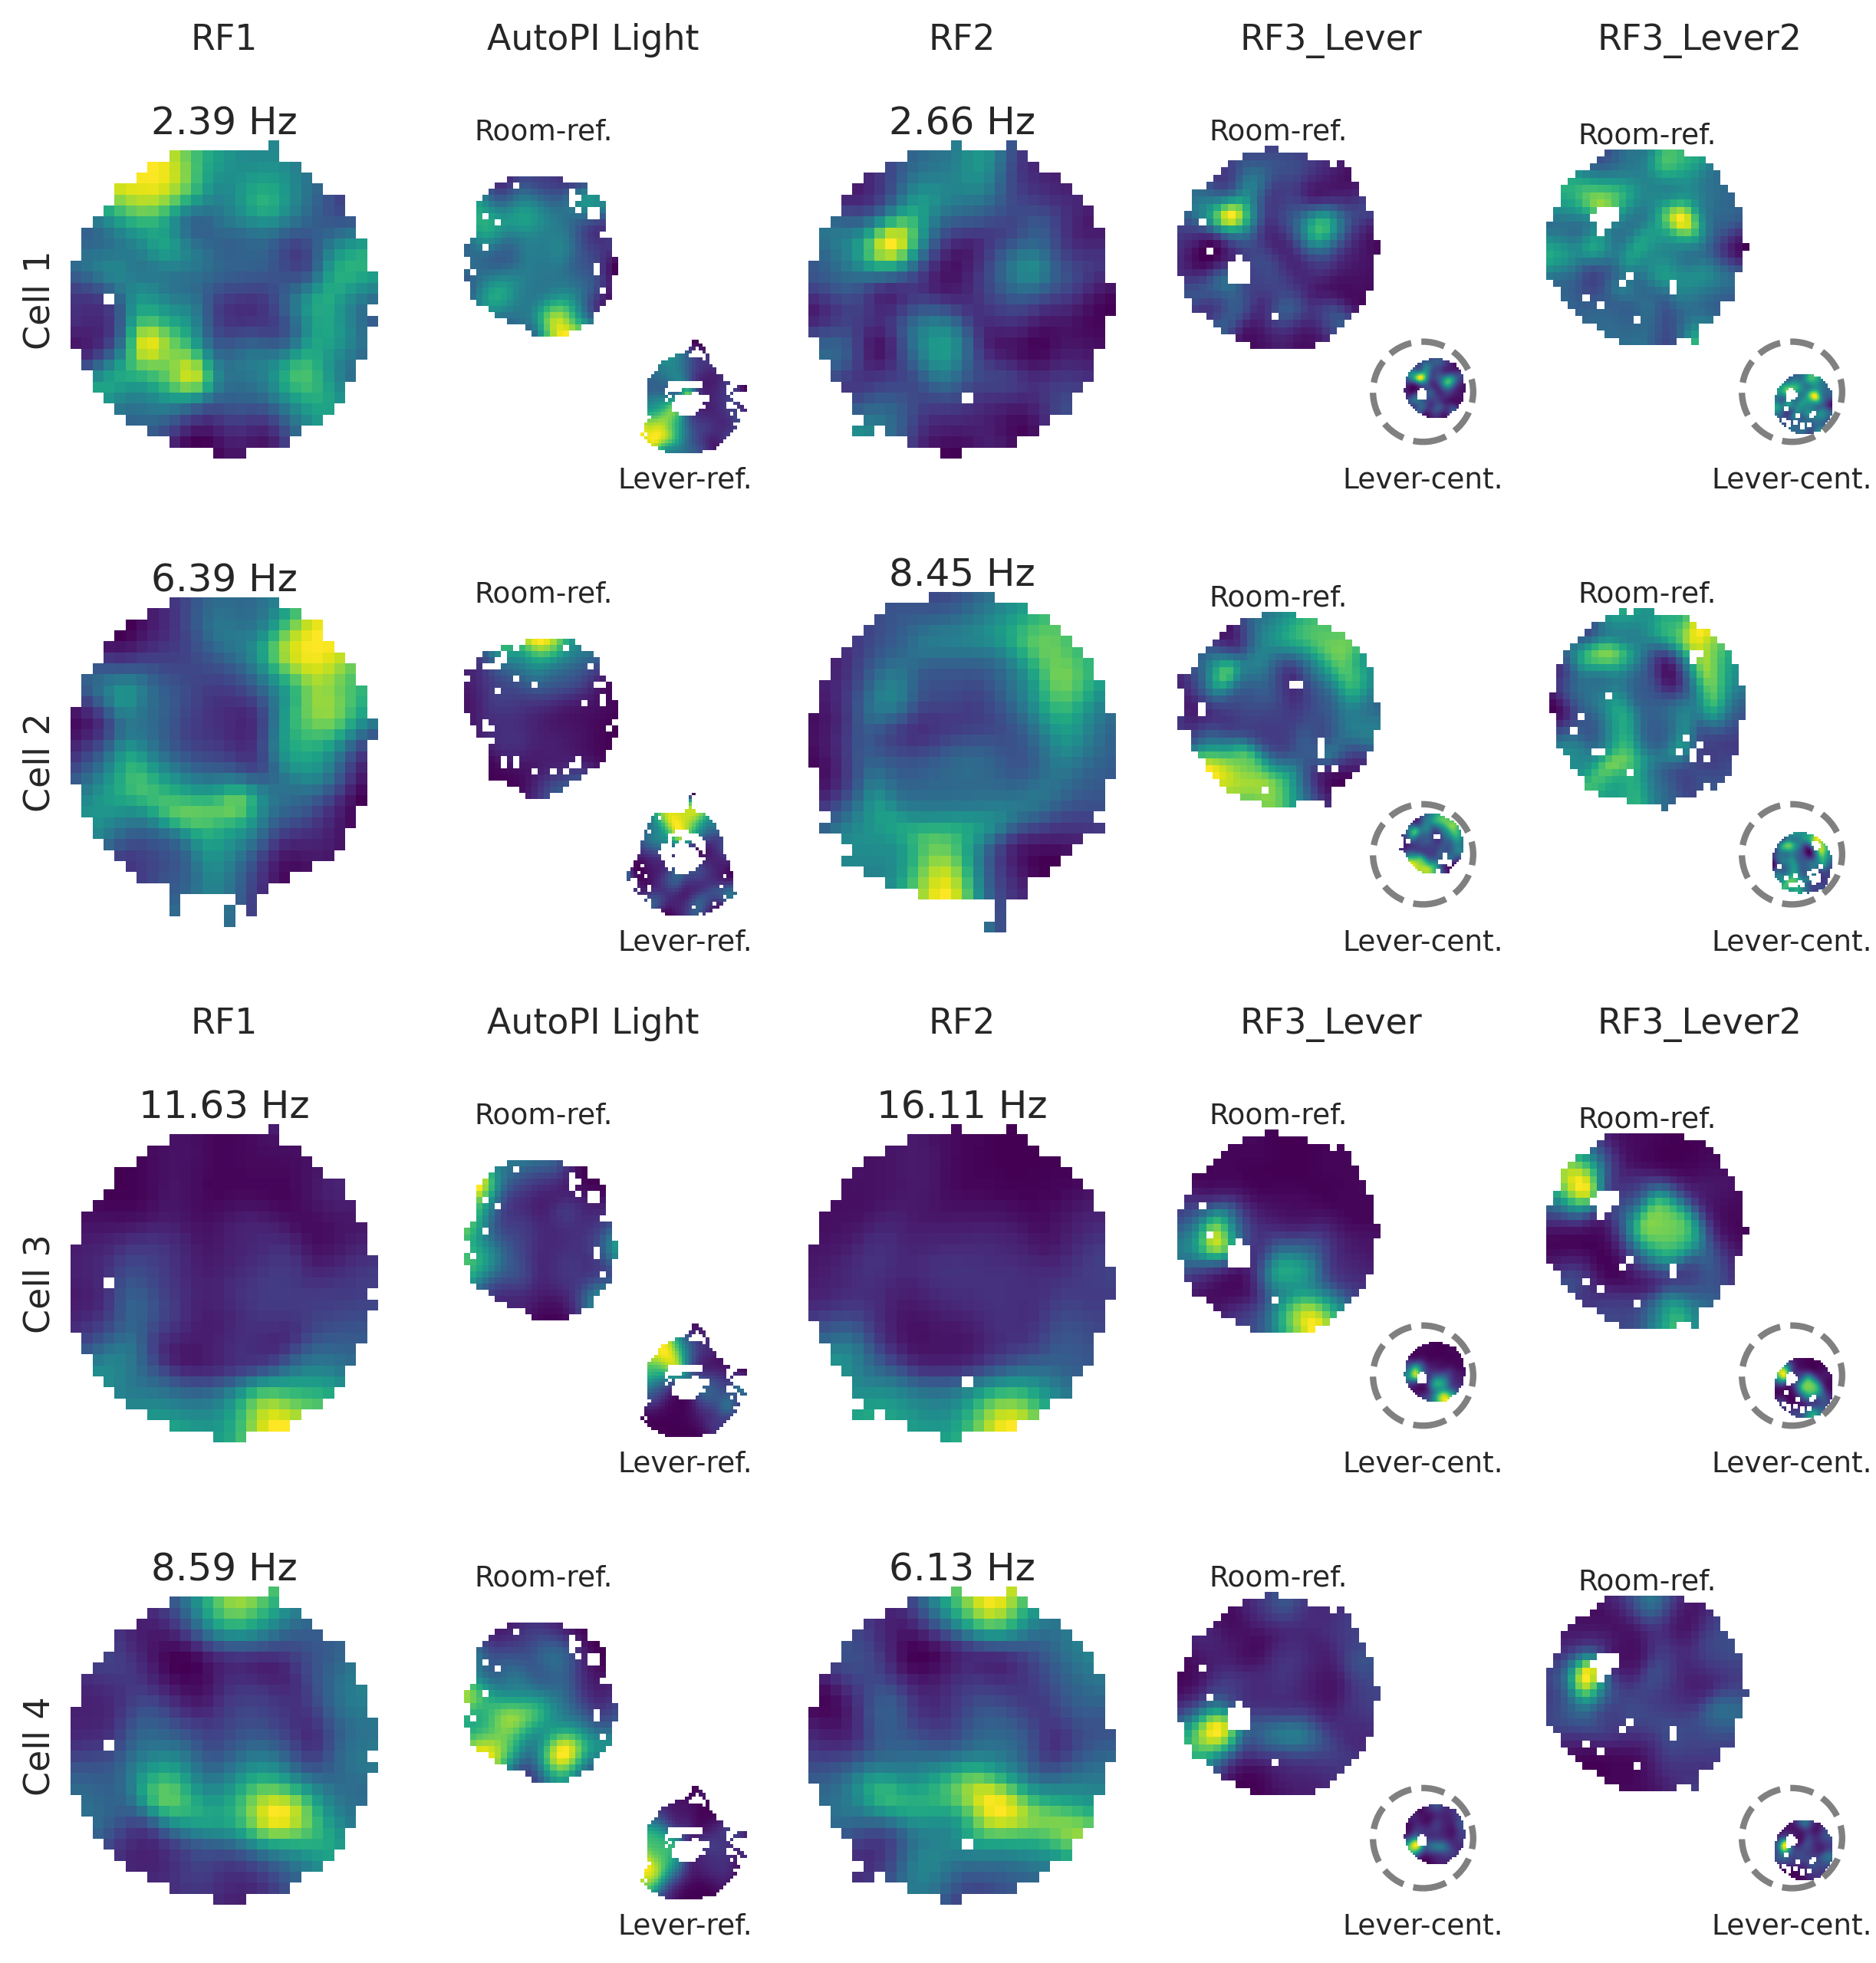

In [80]:
nrows = 6  # Total rows in the main GridSpec
ncols = 5  # Total columns in the main GridSpec
colSize = 2
rowSize = 1.8

#NOTE Set cluid
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_theme(style='ticks')

# Create the main figure with the specified size
fig = plt.figure(figsize=(ncols * colSize, nrows * rowSize), constrained_layout=True)
gs = GridSpec(nrows, ncols, figure=fig,hspace=0.2,wspace=0.2,height_ratios=[0.01,1,1,0.01,1,1])
gsTitle = GridSpecFromSubplotSpec(1,5,subplot_spec=gs[0,:])
gs1 = GridSpecFromSubplotSpec(1,5,subplot_spec=gs[1,:])
gs2 = GridSpecFromSubplotSpec(1,5,subplot_spec=gs[2,:])

gsTitle2 = GridSpecFromSubplotSpec(1,5,subplot_spec=gs[3,:])
gs3 = GridSpecFromSubplotSpec(1,5,subplot_spec=gs[4,:])
gs4 = GridSpecFromSubplotSpec(1,5,subplot_spec=gs[5,:])


titles = ['RF1', 'AutoPI Light', 'RF2', 'RF3_Lever', 'RF3_Lever2']

for i in range(5):
    ax = fig.add_subplot(gsTitle[0, i])
    ax.text(0.5, 0.2, titles[i], fontsize=GLOBALFONTSIZE, ha='center', va='center')
    ax.axis('off')  # Remove spines, ticks, and borders
    
for i in range(5):
    ax = fig.add_subplot(gsTitle2[0, i])
    ax.text(0.5, 0.2, titles[i], fontsize=GLOBALFONTSIZE, ha='center', va='center')
    ax.axis('off')  # Remove spines, ticks, and borders


cluid = 'jp3269-30112022-0110_253'
plot_one_row_of_example_lever_cell(gs1,cluid,ylabel='Cell 1')

cluid = 'jp486-27032023-0110_303'
plot_one_row_of_example_lever_cell(gs2,cluid,ylabel='Cell 2')

cluid = 'jp3269-30112022-0110_328'
plot_one_row_of_example_lever_cell(gs3,cluid,ylabel='Cell 3')

cluid = 'jp3269-30112022-0110_27'
plot_one_row_of_example_lever_cell(gs4,cluid,ylabel='Cell 4')


In [81]:
mapSimilarityDf.columns

Index(['cluId', 'correlation', 'cell1_map', 'cell2_map', 'ori_correlation',
       'cell1_map_ori', 'cell2_map_ori', 'session', 'mouse', 'refractory',
       'refractoryClean', 'usable', 'meanRate', 'sumShortAuto',
       'meanRateStable', 'gridCell_AND', 'gridCell_OR', 'gridCell_FIRST',
       'gridCell', 'leverCell_all_light', 'leverCell_all_dark',
       'roomCorSubtractLeverCor'],
      dtype='object')

In [82]:
# Get a shuffling distribution by rolling position and correlate again

def getShuffledLeverMapsInRF3(ses,sSes,LeverPoseRF3,interName="circ80_lever1",maxDistance=80,smooth=True,iterations=10):
    
    sSes.ap.load_pose_from_file() # get original position data, which file depends on what we used when calling prepareSessionsForSpatialAnalysis
    
    leverX,leverY = LeverPoseRF3
    mouseX = sSes.ap.pose_ori[:,1]-leverX
    mouseY = sSes.ap.pose_ori[:,2]-leverY

    D = np.sqrt(mouseX**2+mouseY**2)
    
    # # NOTE Newly added, set position
    
    sSes.ap.pose_ori[:,1] = mouseX
    sSes.ap.pose_ori[:,2] = mouseY
    
    # # NOTE Newly added, set position
    
    sSes.ap.pose_ori[:,1][D>maxDistance]= np.nan
    sSes.ap.pose_ori[:,2][D>maxDistance]= np.nan

    sSes.ap.set_intervals(ses.intervalDict[interName])

    
    shuffleStack = []
    for i in tqdm(range(iterations)):
        sSes.ap.roll_pose_over_time(min_roll_sec=5) # shuffle the position data on each iteration by a random amount
        cellName_holder = []    
        for n in sSes.cg.neuron_list:
            n.spike_train.set_intervals(ses.intervalDict[interName])
            cluid = f"{ses.name}_{n.name}"
            cellName_holder.append(cluid)
            
            n.spatial_properties.firing_rate_map_2d(cm_per_bin =3, smoothing_sigma_cm = 5, 
                                                    smoothing=smooth,xy_range = np.array([[-maxDistance,-maxDistance],[maxDistance,maxDistance]])) #np.array([[-50,-50],[50,50]]
            
        
        mapList = [ n.spatial_properties.firing_rate_map for n in sSes.cg.neuron_list ]
        mapStack = np.stack(mapList, axis=0)
        shuffleStack.append(mapStack)
        
    
    sSes.ap.load_pose_from_file() # get original position data
    cellStack = np.stack(cellName_holder,axis = 0)
    
    shuffledMap = np.array(shuffleStack)
    shuffledMap_cell_first = np.transpose(shuffledMap, (1, 0, 2, 3))
    
    return shuffledMap_cell_first, cellStack


In [83]:
if:

SyntaxError: invalid syntax (879943805.py, line 1)

# Rerun shuffle df

In [ ]:
# Get shuffling dictionary

# Initialize the dictionary outside the loop
shuffleDic = {}

for session_with_lever in sessionsWithLastLeverSession[:]:
    # Test shuffling to see if it works
    ses, sSes = load_data_for_session(session_with_lever)
    lever_pose_for_session = get_lever_pose_by_sessions(session_with_lever)

    lever1Pose = lever_pose_for_session['circ80_lever1']
    lever2Pose = lever_pose_for_session['circ80_lever2']
    
    shuffled_map1, cell_id_1 = getShuffledLeverMapsInRF3(ses,sSes,LeverPoseRF3=lever1Pose,interName="circ80_lever1",maxDistance=80,iterations=1000)
    shuffled_map2, cell_id_2 = getShuffledLeverMapsInRF3(ses,sSes,LeverPoseRF3=lever2Pose,interName="circ80_lever2",maxDistance=80,iterations=1000)
    
    assert np.all(cell_id_1 == cell_id_2), 'Not equal!'
    
    # Iterate through each cell and its corresponding maps
    for cellId, shuffleMap1, shuffleMap2 in zip(cell_id_1, shuffled_map1, shuffled_map2):
        # Initialize sub-dictionary for the cellId if it doesn't exist
        if cellId not in shuffleDic:
            shuffleDic[cellId] = {'circ80_lever1': [], 'circ80_lever2': []}
        
        # Append the maps to their respective lever type lists
        shuffleDic[cellId]['circ80_lever1'].append(shuffleMap1)
        shuffleDic[cellId]['circ80_lever2'].append(shuffleMap2)

100%|██████████| 1000/1000 [02:40<00:00,  6.24it/s]


In [ ]:
mapSimilarityDf.columns

Index(['cluId', 'correlation', 'cell1_map', 'cell2_map', 'ori_correlation',
       'cell1_map_ori', 'cell2_map_ori', 'Unnamed: 0', 'session', 'mouse',
       'refractory', 'refractoryClean', 'usable', 'meanRate', 'sumShortAuto',
       'bursty', 'burstyScore', 'interneuron', 'meanRateStable',
       'spatiallySelective_AND', 'spatiallySelective_OR',
       'spatiallySelective_FIRST', 'spatiallySelective', 'gridCell_AND',
       'gridCell_OR', 'gridCell_FIRST', 'gridCell', 'HDCell_AND', 'HDCell_OR',
       'HDCell_FIRST', 'HDCell', 'borderCell_AND', 'borderCell_OR',
       'borderCell_FIRST', 'borderCell', 'leverCell_all_light',
       'leverCell_all_dark', 'roomCorSubtractLeverCor'],
      dtype='object')

In [ ]:
shuffleDic.keys()

dict_keys(['jp1686-29042022-0109_25', 'jp1686-29042022-0109_26', 'jp1686-29042022-0109_27', 'jp1686-29042022-0109_28', 'jp1686-29042022-0109_39', 'jp1686-29042022-0109_54', 'jp1686-29042022-0109_64', 'jp1686-29042022-0109_67', 'jp1686-29042022-0109_72', 'jp1686-29042022-0109_86', 'jp1686-29042022-0109_91', 'jp1686-29042022-0109_99', 'jp1686-29042022-0109_105', 'jp1686-29042022-0109_107', 'jp1686-29042022-0109_109', 'jp1686-29042022-0109_111', 'jp1686-29042022-0109_113', 'jp1686-29042022-0109_115', 'jp1686-29042022-0109_117', 'jp1686-29042022-0109_119', 'jp1686-29042022-0109_123', 'jp1686-29042022-0109_125', 'jp1686-29042022-0109_141', 'jp1686-29042022-0109_143', 'jp1686-29042022-0109_145', 'jp1686-29042022-0109_147', 'jp1686-29042022-0109_159', 'jp1686-29042022-0109_167', 'jp1686-29042022-0109_175', 'jp1686-29042022-0109_181', 'jp1686-29042022-0109_185', 'jp1686-29042022-0109_187', 'jp1686-29042022-0109_189', 'jp1686-29042022-0109_193', 'jp1686-29042022-0109_201', 'jp1686-29042022-0109

In [ ]:
shuffledCorrholder = []
cellNameHolder = []

for cellId in mapSimilarityDf.cluId.unique(): 
    map1 = np.array(mapDictionary[cellId]['circ80_lever1'])
    
    shuffled_maps = shuffleDic[cellId]['circ80_lever1'][0]
    
    for i in range(shuffled_maps.shape[0]): 
        map2 = shuffled_maps[i]
        
        # Correlate them
        r,_,_=map_cor(map1,map2)
        cellNameHolder.append(cellId)
        shuffledCorrholder.append(r)

/home/kilo/miniconda3/envs/spikeA/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
shuffledCorrDf = pd.DataFrame({'cellName':cellNameHolder,'correlation':shuffledCorrholder})

In [ ]:
shuffledCorrDf

,cellName,correlation
0,jp3269-30112022-0110_281,-0.236737
1,jp3269-30112022-0110_281,-0.122574
2,jp3269-30112022-0110_281,-0.286230
3,jp3269-30112022-0110_281,-0.391383
4,jp3269-30112022-0110_281,-0.168343
...,...,...
251995,jp3269-30112022-0110_23,NaN
251996,jp3269-30112022-0110_23,NaN
251997,jp3269-30112022-0110_23,NaN
251998,jp3269-30112022-0110_23,NaN


In [ ]:
shuffleFn = 'shuffle_rf3_lever_dataframe.csv'
fn = myProject.dataPath + '/results/' + shuffleFn

In [ ]:
#shuffledCorrDf.to_csv(fn)

# Load shuffle df and make figure

In [84]:
shuffleFn = 'shuffle_rf3_lever_dataframe.csv'
fn = myProject.dataPath + '/results/' + shuffleFn

shuffledCorrDf = pd.read_csv(fn,index_col=0)

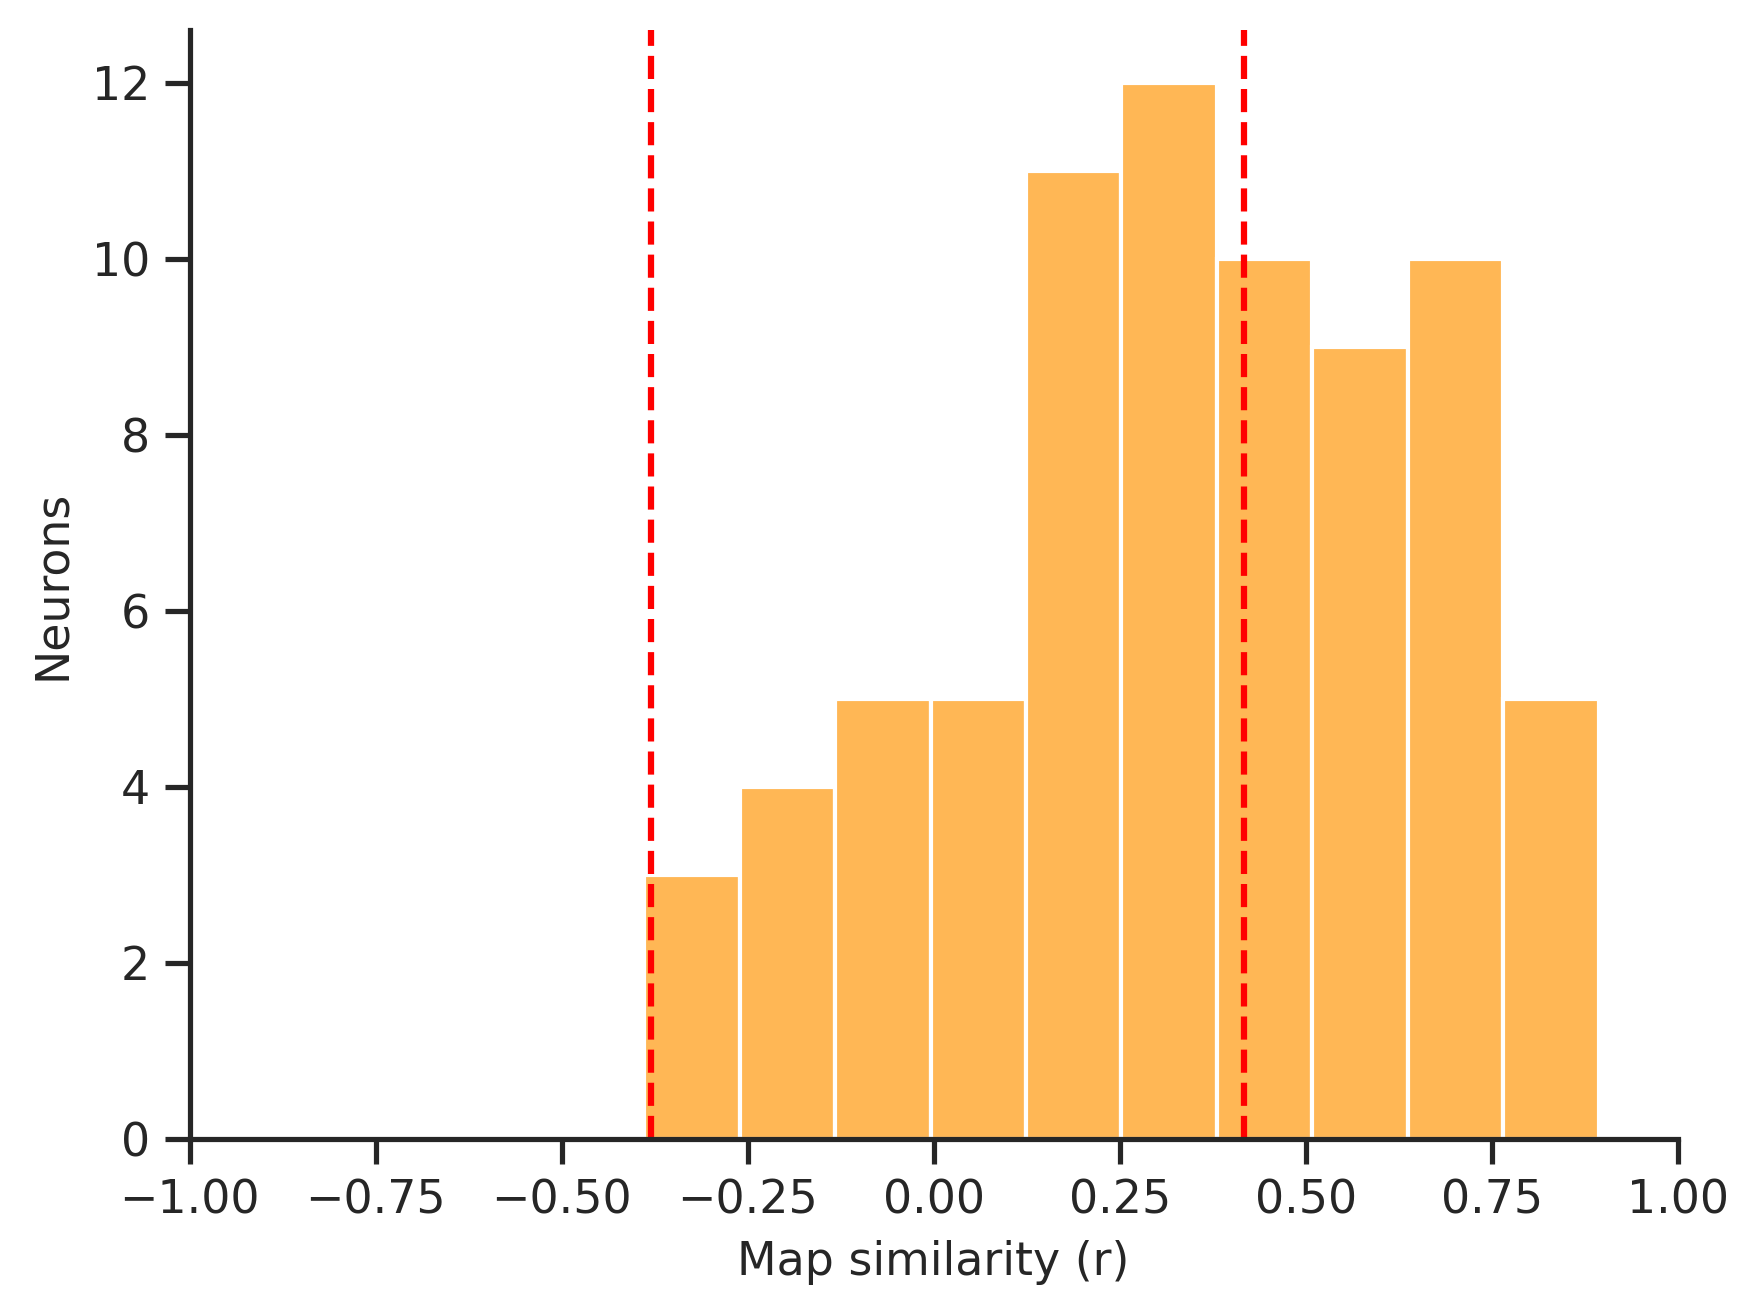

In [85]:
fig, ax =plt.subplots()

def plot_non_grid_cell_correlation(ax,shuffledCorrDf,mapSimilarityDf,c='#ff9f1c'):
    shuffledCorrDf = shuffledCorrDf.dropna()

    sns.histplot(data=mapSimilarityDf[(~mapSimilarityDf.gridCell_FIRST)],x='correlation',bins=10,ax=ax,color=c)

    # Calculate the 95th percentile values
    left_percentile = np.percentile(shuffledCorrDf['correlation'], 2.5)
    right_percentile = np.percentile(shuffledCorrDf['correlation'], 97.5)

    # Plot vertical lines for the 95th percentile
    ax.axvline(left_percentile, color='red', linestyle='--', label='2.5th Percentile')
    ax.axvline(right_percentile, color='red', linestyle='--', label='97.5th Percentile')

    ax.set_xlim(-1,1)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xlabel('Map similarity (r)',fontsize=GLOBALFONTSIZE)
    ax.set_ylabel('Neurons',fontsize=GLOBALFONTSIZE)
    
plot_non_grid_cell_correlation(ax,shuffledCorrDf=shuffledCorrDf,mapSimilarityDf=mapSimilarityDf[mapSimilarityDf.leverCell_all_light])

In [86]:
def plot_one_row_of_example_lever_cell_with_map_sim(gs0,cluid,ylabel,mapSimDf):

    ax0 = fig.add_subplot(gs0[0,0])
    plotmap(ax0,cluid,myMaps,condition='circ80_1')
    ax0.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)

    ax0 = fig.add_subplot(gs0[0,1])
    plot_room_lever_partial_map(ax0,cluid,condition='all_light')

    ax0 = fig.add_subplot(gs0[0,2])
    plotmap(ax0,cluid,myMaps,condition='circ80_2')

    ax0 = fig.add_subplot(gs0[0,3])
    plot_room_lever_partial_map_RF3(ax0,cluid,condition='circ80_lever1')
    
    axT = fig.add_subplot(gs0[0,4])
    plot_room_lever_partial_map_RF3(axT,cluid,condition='circ80_lever2')
    
    leverMapCorr = round(mapSimDf[mapSimDf.cluId == cluid].correlation.values[0],2)
    
    axT.text(0.15,0.05,f'Lever-cent.\nr: {leverMapCorr}',
             verticalalignment ='center', 
        horizontalalignment ='center', 
        transform = axT.transAxes,fontsize=GLOBALFONTSIZE-2)

In [87]:
def print_lever_cell_and_correlation(cellId,mapSimilarityDf=mapSimilarityDf):
    dfSlice = mapSimilarityDf[mapSimilarityDf.cluId == cellId]
    
    lever_cor = dfSlice.correlation.values[0]
    map_corr = dfSlice.ori_correlation.values[0]
    
    print('*******')
    print(f'Cell {cellId}')
    print('Lever corr',lever_cor)
    print('Map corr',map_corr)

In [88]:
def add_text(ax, x, y, label, fw="normal"):
    ax.text(
        x,
        y,
        label,
        style="normal",
        fontweight=fw,
        fontsize=GLOBALFONTSIZE + 4,
        verticalalignment="center",
        horizontalalignment="center",
        transform=ax.transAxes,
    )

*******
Cell jp3269-30112022-0110_328
Lever corr 0.8099329721013537
Map corr 0.13505406170840847
*******
Cell jp3269-30112022-0110_27
Lever corr 0.7876406670184709
Map corr 0.15558465711513625
*******
Cell jp3269-30112022-0110_253
Lever corr -0.04355823220966192
Map corr 0.5127771046985389
*******
Cell jp486-27032023-0110_303
Lever corr -0.03236005792303299
Map corr 0.6936356275264434


/tmp/ipykernel_115550/2762757264.py:73: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('../../Output/Sup_Figure4.pdf', bbox_inches='tight', dpi=300)
/tmp/ipykernel_115550/2762757264.py:73: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('../../Output/Sup_Figure4.pdf', bbox_inches='tight', dpi=300)
/home/kilo/miniconda3/envs/spikeA/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


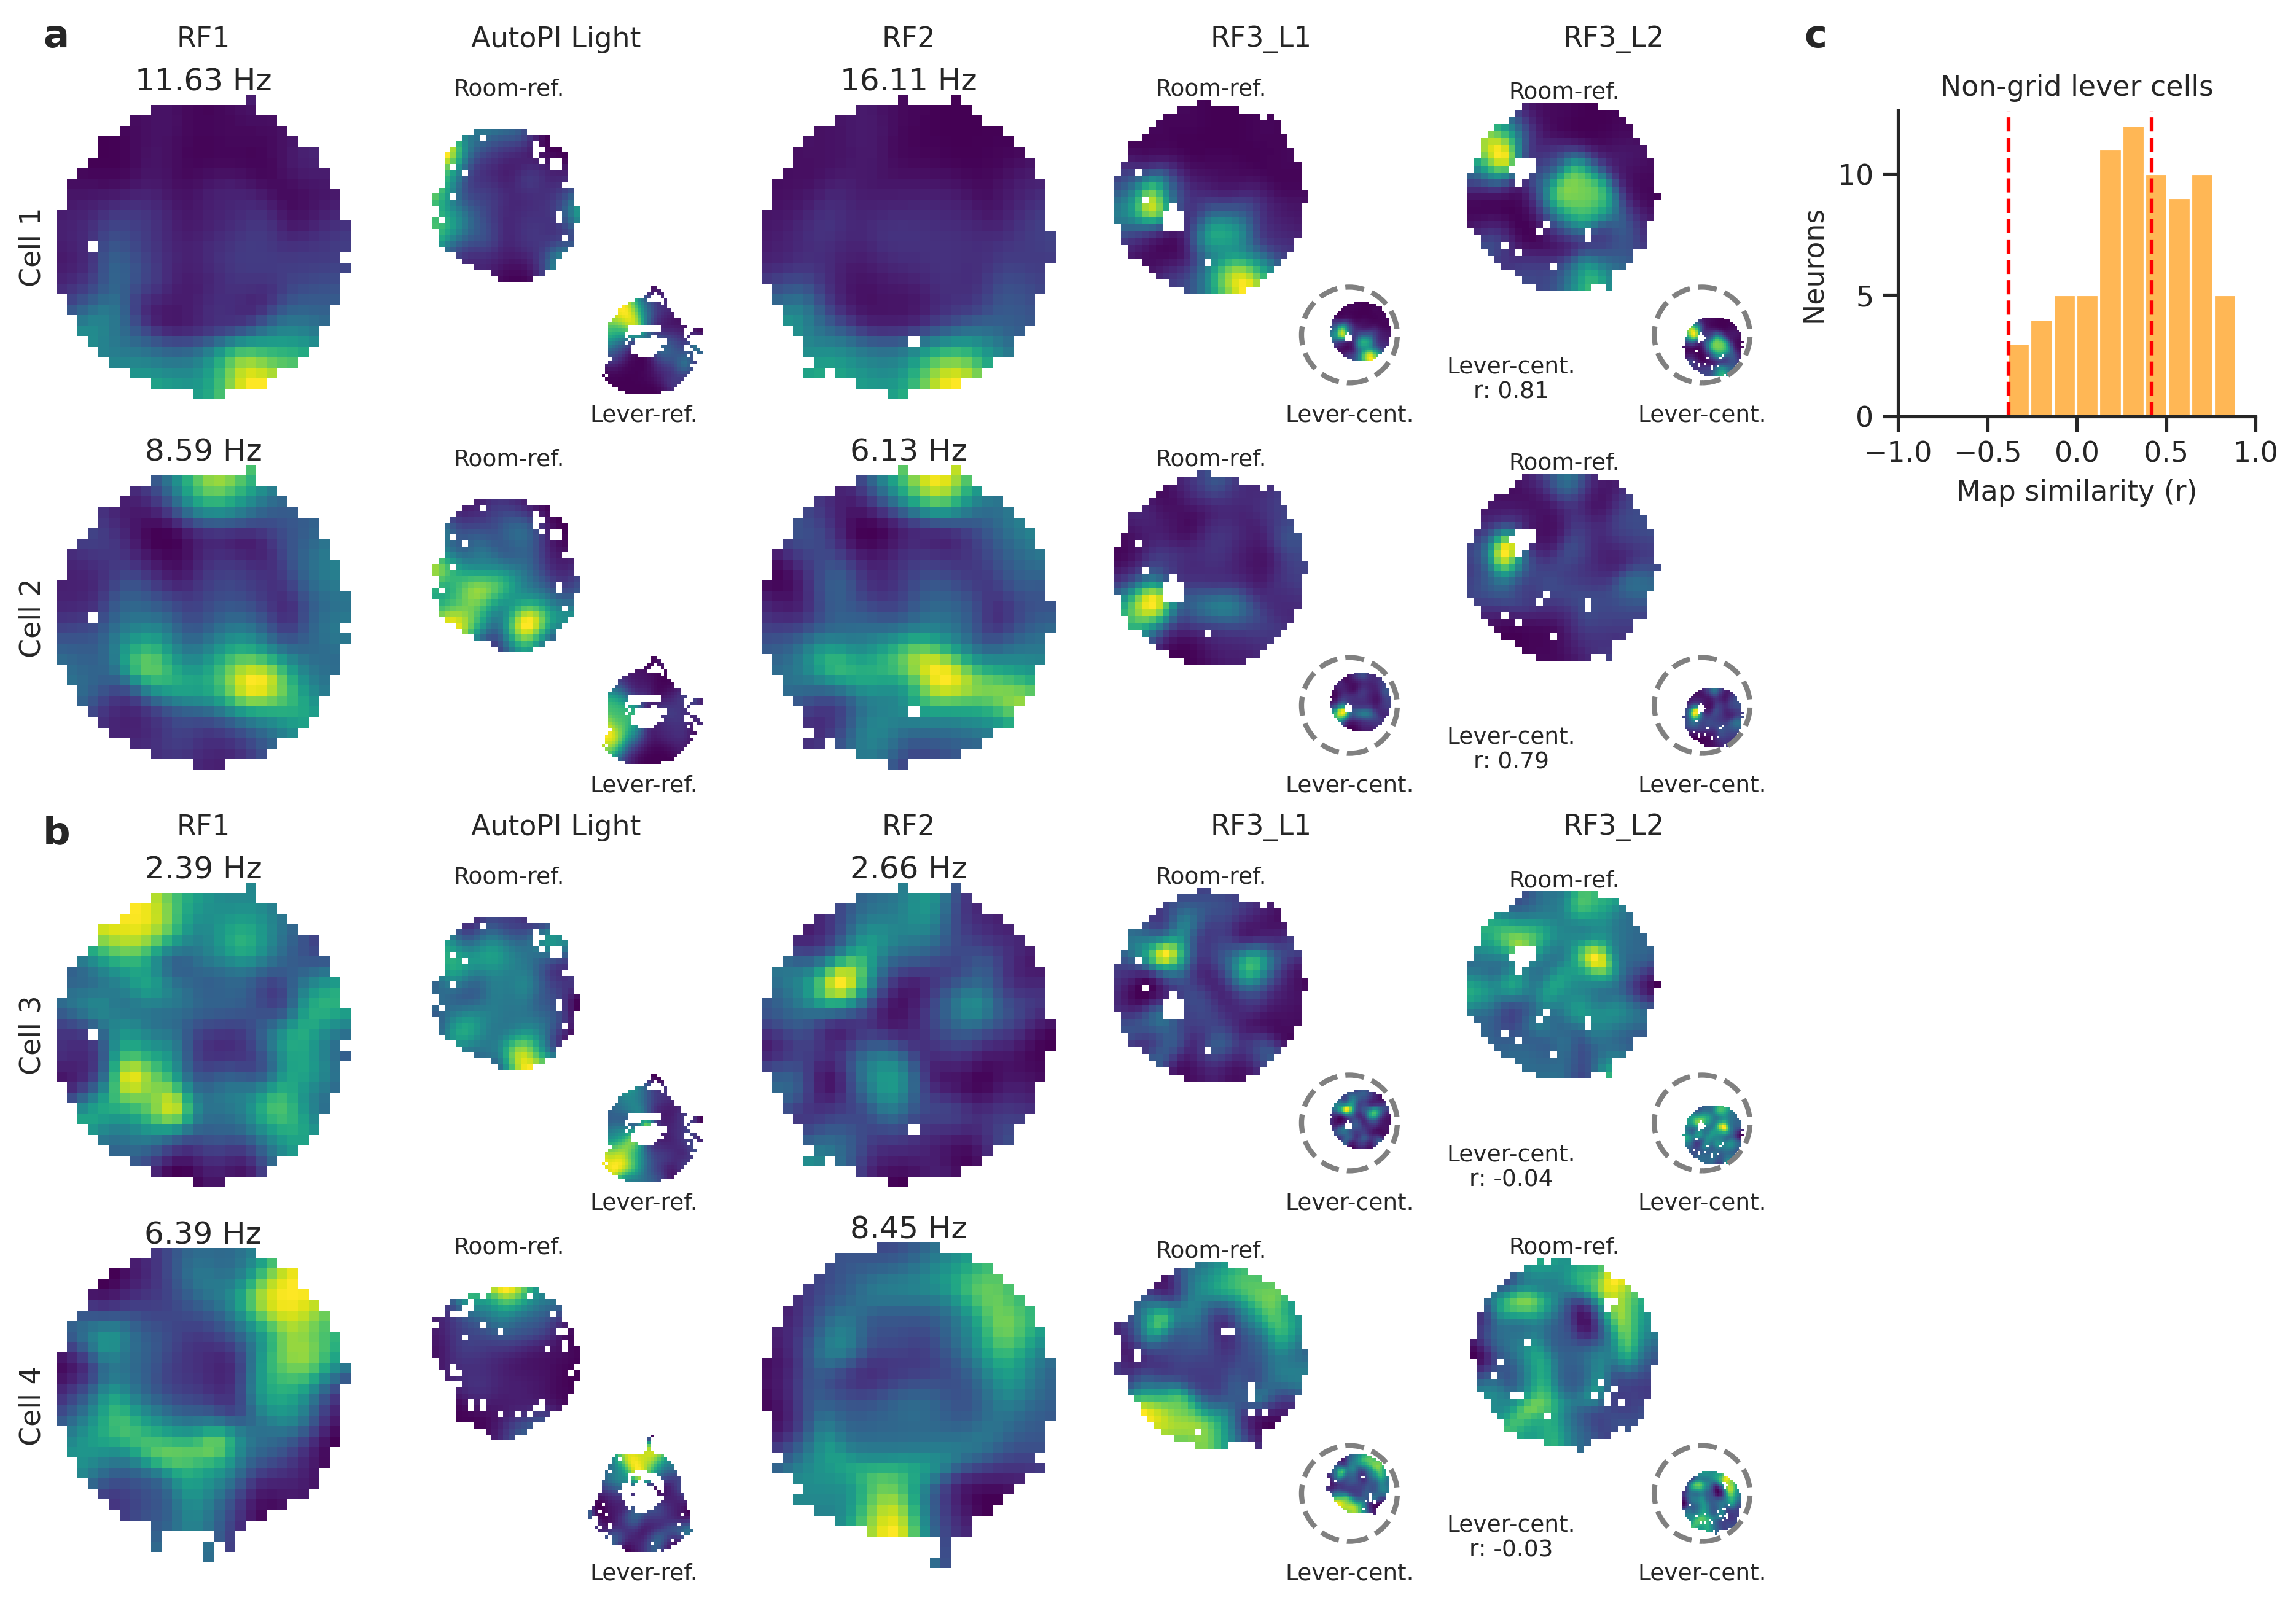

In [89]:
nrows = 6  # Total rows in the main GridSpec
ncols = 7  # Total columns in the main GridSpec
colSize = 2.2
rowSize = 1.8

sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_theme(style='ticks')

# Create the main figure with the specified size
fig = plt.figure(figsize=(ncols * colSize, nrows * rowSize), constrained_layout=True)
gs = GridSpec(nrows, ncols, figure=fig,hspace=0.2,height_ratios=[0.01,1,1,0.01,1,1],width_ratios=[1]*5+[0.1]+[1.2])
gsTitle = GridSpecFromSubplotSpec(1,5,subplot_spec=gs[0,:5])
gs1 = GridSpecFromSubplotSpec(1,5,subplot_spec=gs[1,:5])
gs2 = GridSpecFromSubplotSpec(1,5,subplot_spec=gs[2,:5])

gsTitle2 = GridSpecFromSubplotSpec(1,5,subplot_spec=gs[3,:5])
gs3 = GridSpecFromSubplotSpec(1,5,subplot_spec=gs[4,:5])
gs4 = GridSpecFromSubplotSpec(1,5,subplot_spec=gs[5,:5])
gsStats = GridSpecFromSubplotSpec(6,1,subplot_spec=gs[:,6],height_ratios=[0.1,1,0.2,1,1,1])


titles = ['RF1', 'AutoPI Light', 'RF2', 'RF3_L1', 'RF3_L2']

for i in range(5):
    ax = fig.add_subplot(gsTitle[0, i])
    ax.text(0.5, 0.2, titles[i], fontsize=GLOBALFONTSIZE, ha='center', va='center')
    ax.axis('off')  # Remove spines, ticks, and borders
    
for i in range(5):
    ax = fig.add_subplot(gsTitle2[0, i])
    ax.text(0.5, 0.2, titles[i], fontsize=GLOBALFONTSIZE, ha='center', va='center')
    ax.axis('off')  # Remove spines, ticks, and borders



cluid = 'jp3269-30112022-0110_328'
plot_one_row_of_example_lever_cell_with_map_sim(gs1,cluid,ylabel='Cell 1',mapSimDf=mapSimilarityDf)
print_lever_cell_and_correlation(cluid)

cluid = 'jp486-27032023-0110_744'

cluid = 'jp3269-30112022-0110_27'
plot_one_row_of_example_lever_cell_with_map_sim(gs2,cluid,ylabel='Cell 2',mapSimDf=mapSimilarityDf)
print_lever_cell_and_correlation(cluid)

cluid = 'jp3269-30112022-0110_253'
plot_one_row_of_example_lever_cell_with_map_sim(gs3,cluid,ylabel='Cell 3',mapSimDf=mapSimilarityDf)
print_lever_cell_and_correlation(cluid)

cluid = 'jp486-27032023-0110_303'
plot_one_row_of_example_lever_cell_with_map_sim(gs4,cluid,ylabel='Cell 4',mapSimDf=mapSimilarityDf)
print_lever_cell_and_correlation(cluid)


ax0 = fig.add_subplot(gsStats[1])
plot_non_grid_cell_correlation(ax0,shuffledCorrDf=shuffledCorrDf,mapSimilarityDf=mapSimilarityDf[mapSimilarityDf.leverCell_all_light])
ax0.set_title('Non-grid lever cells',fontsize=GLOBALFONTSIZE)


# NOTE Add figure legends
gs1 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:,:])
#***********************************#
ax0 = fig.add_subplot(gs1[:,:])

#Add figure legend
add_text(ax0,0,1,'a',fw='900')
add_text(ax0,0,0.48,'b',fw='900')
add_text(ax0,0.8,1,'c',fw='900')

ax0.axis('off')
# ###

plt.savefig('../../Output/Sup_Figure4.pdf', bbox_inches='tight', dpi=300)